<a href="https://colab.research.google.com/github/Yunseokjin/Final-Team1/blob/main/(%EC%A0%84%EC%B2%98%EB%A6%AC%ED%8C%8C%EC%9D%BC)%EA%B0%80%EC%84%A4_1_%22%EB%A6%AC%EB%B7%B0%EC%9D%98_'%EA%B3%A8%EB%93%A0_%ED%83%80%EC%9E%84'%EC%9D%80_%EC%A1%B4%EC%9E%AC%ED%95%A0%EA%B9%8C%3F_%EC%B6%9C%EC%8B%9C_%EC%B4%88%EA%B8%B0_vs_%EC%95%88%EC%A0%95%EA%B8%B0_%EB%A6%AC%EB%B7%B0_%ED%8C%A8%ED%84%B4_%EB%B6%84%EC%84%9D%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 가설 1: "리뷰의 '골든 타임'은 존재할까? - 출시 초기 vs 안정기 리뷰 패턴 분석"

In [ ]:
df = pd.read_csv('/content/weighted_score_above_08_250924.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188273 entries, 0 to 188272
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ﻿"﻿""recommendationid"""        188273 non-null  int64  
 1   appid                           188273 non-null  int64  
 2   game                            188260 non-null  object 
 3   author_steamid                  188273 non-null  int64  
 4   author_num_games_owned          188273 non-null  int64  
 5   author_num_reviews              188273 non-null  int64  
 6   author_playtime_forever         188273 non-null  int64  
 7   author_playtime_last_two_weeks  188273 non-null  int64  
 8   author_playtime_at_review       188273 non-null  int64  
 9   author_last_played              188273 non-null  object 
 10  language                        188273 non-null  object 
 11  review                          130202 non-null  object 
 12  timestamp_create

##  0.라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import chi2_contingency
from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/weighted_score_above_08_250924.csv')

## 1.데이터준비 (그룹 나누기)

- 그룹 설명 (4가지 그룹)
    - 각 그룹 별 초기리뷰와 안정기 이후의 리뷰를 나눈다.
    - 게임 출시일 칼럼이 없으므로 첫 리뷰 날짜를 출시일('timestamp_created')로 정의한다. (게임은 'appid'칼럼 사용)

|장르 유형	|특징	|대표 장르 (데이터셋 예시)	|초기(Early) 기준	|안정기(Stable) 기준|
|--|--|--|--|--|
|라이브 서비스	|장기적이고 지속적인 플레이를 기대 (엔드 콘텐츠, 시즌제)|	Action, Massively Multiplayer, Free to Play|	60일 이내|	365일 이후|
|스토리/캠페인 중심	|정해진 엔딩을 향해 달려가는 경험	|Adventure, RPG	|30일 이내	|180일 이후|
|전략/시뮬레이션/인디|	반복 플레이나 짧은 경험이 핵심|	Strategy, Simulation, Indie, Casual	|30일 이내	|90일 이후|
|기타 (Default)	|위 분류에 속하지 않는 나머지|	나머지 모든 장르|	30일 이내|	180일 이후|

### 1_1.기본 전처리 ('timestamp_created' 칼럼 datetime 형식으로 변환)
- 'timestamp_created'를 datetime 형식으로 변환
- 장르 컬럼 결측치를 빈 문자열('')로 채우기
- 필수 컬럼('timestamp_created')에 결측치가 있는 행 제거

In [ ]:
# 'timestamp_created'를 datetime 형식으로 변환
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], errors='coerce')
# 장르 컬럼 결측치를 빈 문자열('')로 채우기
df[['genres1', 'genres2', 'genres3']] = df[['genres1', 'genres2', 'genres3']].fillna('')
# 필수 컬럼에 결측치가 있는 행 제거
df.dropna(subset=['timestamp_created'], inplace=True)

### 1_2.그룹 나누기(출시일 계산, 장르키워드 정의)
- '출시일', '출시일 후 경과일' 계산
- 장르 키워드 정의
- 장르별 분류

In [ ]:
# 출시일 계산 및 시점 분류
# 각 게임(appid)의 첫 리뷰 날짜를 '사실상 출시일'로 정의
df['release_date'] = df.groupby('appid')['timestamp_created'].transform('min')
# '출시 후 경과일' 계산
df['days_since_release'] = (df['timestamp_created'] - df['release_date']).dt.days

In [ ]:
# 장르 키워드 정의
live_service_keywords = {'Action', 'Massively Multiplayer', 'Free to Play'}
story_keywords = {'Adventure', 'RPG'}
strategy_indie_keywords = {'Strategy', 'Simulation', 'Indie', 'Casual'}

In [ ]:
def classify_phase_by_all_genres(row):
    """3개 장르를 모두 확인하여 리뷰 시점을 분류하는 함수"""
    days = row['days_since_release']
    game_genres = {str(row['genres1']), str(row['genres2']), str(row['genres3'])}

    if not live_service_keywords.isdisjoint(game_genres):
        if days <= 60: return 'Early'
        elif days >= 365: return 'Stable'
        else: return 'Mid-term'
    elif not story_keywords.isdisjoint(game_genres):
        if days <= 30: return 'Early'
        elif days >= 180: return 'Stable'
        else: return 'Mid-term'
    elif not strategy_indie_keywords.isdisjoint(game_genres):
        if days <= 30: return 'Early'
        elif days >= 90: return 'Stable'
        else: return 'Mid-term'
    else:
        if days <= 30: return 'Early'
        elif days >= 180: return 'Stable'
        else: return 'Mid-term'

In [ ]:
# 'review_phase' 컬럼 생성
df['review_phase'] = df.apply(classify_phase_by_all_genres, axis=1)

# 분석용 데이터프레임(df_analysis) 생성
df_analysis = df[df['review_phase'].isin(['Early', 'Stable'])].copy()

In [ ]:
def get_genre_group(row):
    """시각화 및 그룹 분석을 위한 장르 그룹핑 함수"""
    game_genres = {str(row['genres1']), str(row['genres2']), str(row['genres3'])}
    if not live_service_keywords.isdisjoint(game_genres): return 'Live Service'
    elif not story_keywords.isdisjoint(game_genres): return 'Story-driven'
    elif not strategy_indie_keywords.isdisjoint(game_genres): return 'Strategy/Indie'
    else: return 'Others'

df_analysis['genre_group'] = df_analysis.apply(get_genre_group, axis=1)

print("데이터 분할 및 그룹핑 완료!")
print(df_analysis['genre_group'].value_counts())
print("-" * 50)

데이터 분할 및 그룹핑 완료!
genre_group
Live Service      84799
Story-driven      36358
Strategy/Indie    31385
Others             8735
Name: count, dtype: int64
--------------------------------------------------


##2.카이제곱검정 + 크래머's V (영향력 평가)

In [ ]:
def cramers_v(contingency_table):
    """크라메르 V 계수를 계산하는 함수"""
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    if n == 0: return 0
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    if min((k_corr-1), (r_corr-1)) == 0: return 0
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# 'review_phase'와 영향력 지표 간의 연관성 분석 (전체 데이터 대상)
print("\n[전체 데이터 대상: 리뷰 시점과 영향력 지표 간 연관성 분석]")
for metric in ['votes_up', 'votes_funny', 'comment_count']:
    df_analysis[f'{metric}_group'] = np.where(df_analysis[metric] > 0, 'Reaction', 'No Reaction')
    contingency_table = pd.crosstab(df_analysis['review_phase'], df_analysis[f'{metric}_group'])

    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    v = cramers_v(contingency_table.values)

    print(f"\n- '{metric}' 분석 결과:")
    print(f"  - p-value: {p_value:.4f}, 크라메르 V: {v:.4f}")
    if p_value < 0.05: print("  -> 결론: 통계적으로 '유의미한 연관성'이 있습니다.")
    else: print("  -> 결론: 통계적으로 유의미한 연관성이 없습니다.")


[전체 데이터 대상: 리뷰 시점과 영향력 지표 간 연관성 분석]

- 'votes_up' 분석 결과:
  - p-value: 0.3773, 크라메르 V: 0.0000
  -> 결론: 통계적으로 유의미한 연관성이 없습니다.

- 'votes_funny' 분석 결과:
  - p-value: 0.0000, 크라메르 V: 0.0418
  -> 결론: 통계적으로 '유의미한 연관성'이 있습니다.

- 'comment_count' 분석 결과:
  - p-value: 0.0000, 크라메르 V: 0.0917
  -> 결론: 통계적으로 '유의미한 연관성'이 있습니다.



장르별 영향력 분포 시각화를 생성합니다...


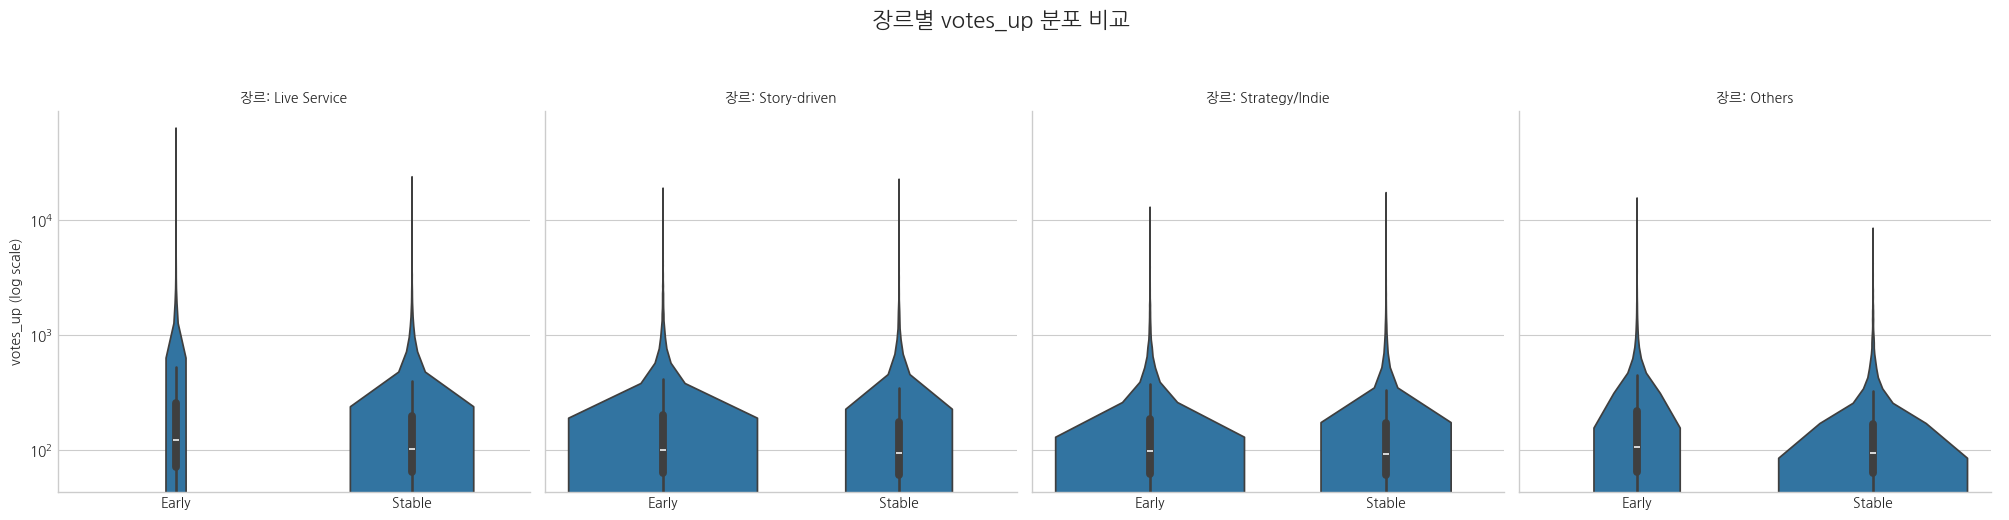

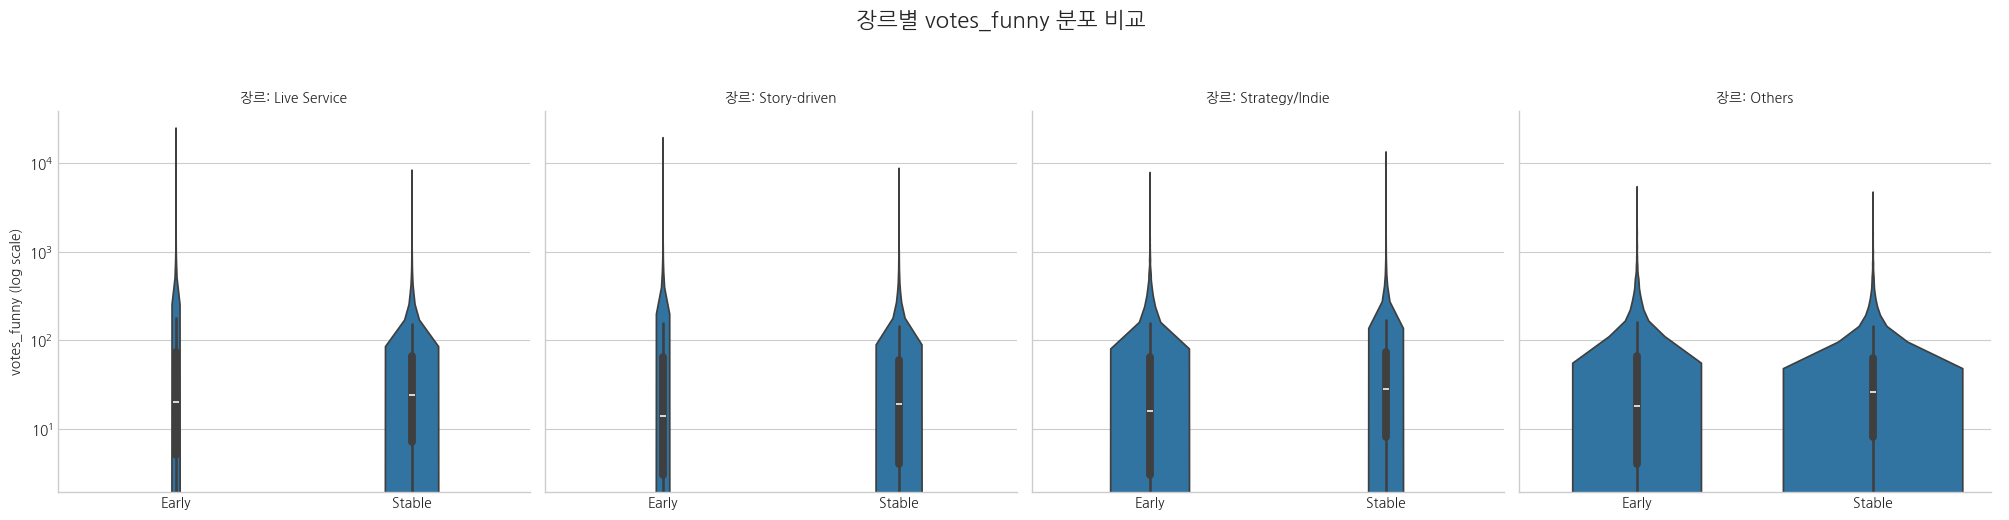

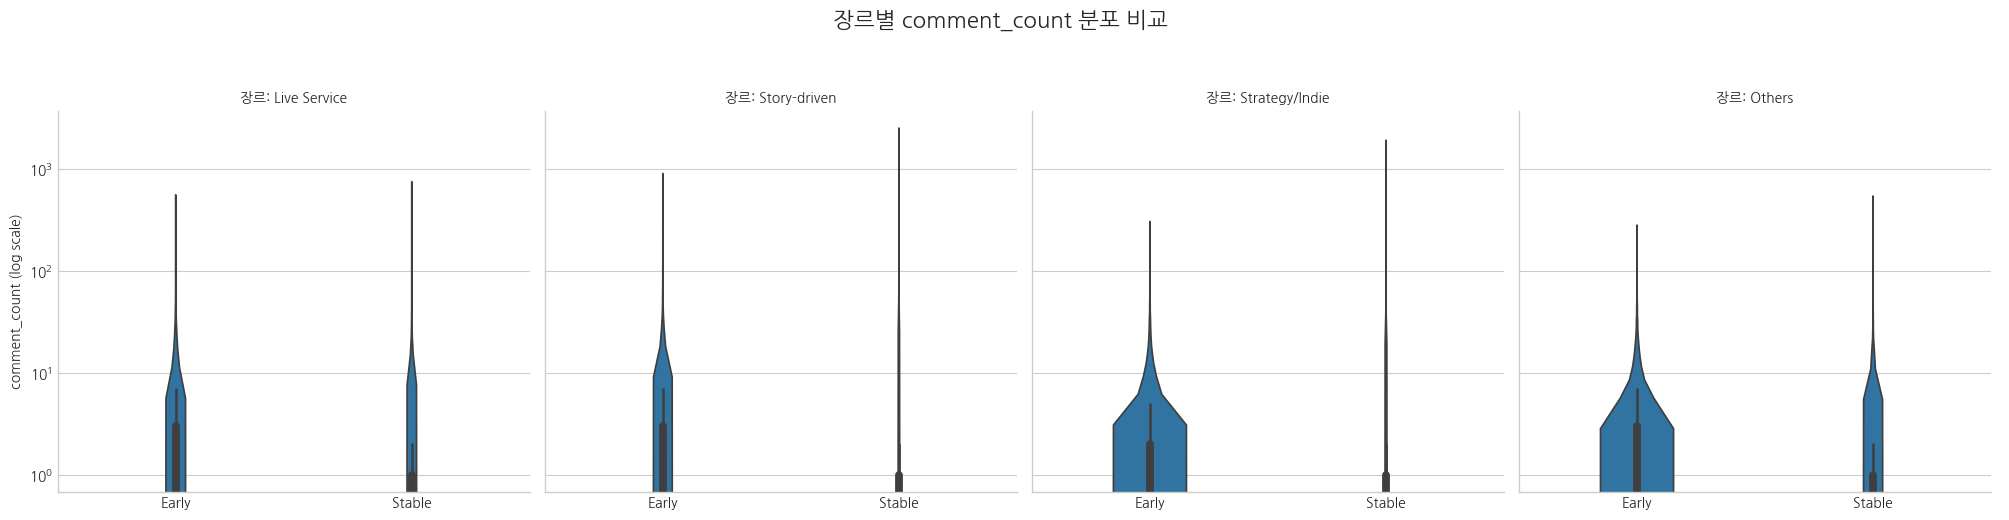

--------------------------------------------------


In [ ]:
# 장르별 영향력 시각화 (Violin Plot)
print("\n장르별 영향력 분포 시각화를 생성합니다...")
for metric in ['votes_up', 'votes_funny', 'comment_count']:
    g = sns.catplot(data=df_analysis, x='review_phase', y=metric, col='genre_group',
                    kind='violin', col_wrap=4, sharey=True, order=['Early', 'Stable'], cut=0)
    g.fig.suptitle(f'장르별 {metric} 분포 비교', y=1.03, fontsize=16)
    g.set_axis_labels("", f"{metric} (log scale)")
    g.set_titles("장르: {col_name}")
    g.set(yscale='log')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
print("-" * 50)

## 3.장르별 키워드 추출

In [ ]:
# --- 5-1. KoNLPy 설치 (Colab 환경에서 필요) ---
try:
    import konlpy
except ImportError:
    !pip install konlpy
from konlpy.tag import Okt
from collections import Counter

In [ ]:
df_english = df_analysis[df_analysis['language'] != 'koreana'].copy()
df_korean = df_analysis[df_analysis['language'] == 'koreana'].copy()
print(f"분석 대상: 영어 리뷰 {len(df_english)}개, 한국어 리뷰 {len(df_korean)}개")

분석 대상: 영어 리뷰 158965개, 한국어 리뷰 2312개


### 3_1.한국어 아닌 리뷰 키워드

In [ ]:
# 키워드 분석 함수
def extract_top_keywords(text_series, stopwords, n_top=15):
    """TF-IDF와 커스텀 불용어를 사용해 핵심 키워드를 추출하는 함수"""
    if text_series.empty or text_series.str.strip().eq('').all():
        print("  -> 리뷰 텍스트가 없어 키워드 추출을 건너뜁니다.")
        return

    tfidf_vec = TfidfVectorizer(stop_words=stopwords, max_df=0.85, min_df=5, max_features=1000)

    try:
        tfidf_matrix = tfidf_vec.fit_transform(text_series)
        feature_names = np.array(tfidf_vec.get_feature_names_out())
        avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
        top_indices = avg_tfidf_scores.argsort()[::-1][:n_top]

        print(f"  (상위 {n_top}개 키워드)")
        for word, score in zip(feature_names[top_indices], avg_tfidf_scores[top_indices]):
            print(f"  - {word}: {score:.4f}")

    except ValueError as e:
        print(f"  -> TF-IDF 분석 중 오류 발생 (데이터 부족 가능성): {e}")

In [ ]:
# 영어 리뷰 분석
# [최종 정제용 불용어 리스트]
custom_stopwords_en = list(text.ENGLISH_STOP_WORDS) + [
    'game', 'games', 'play', 'playing', 'player', 'players', 'just', 'like', 'don', 've',
    'good', 'time', 'fun', 'really', 'people', 'want', 'need', 'got', 'going', 'buy',
    'bought', 'make', 'know', 'think', 'great', 'better', 'best', 'lot', 'little',
    'll', 'hours', 'new', 'day', 'life', 'steam', 'money', 'love', 'say', 'bad',
    'years', 'old', 'way', 'man', 'bit', 'real', 'didn', 'able', 'use', 'work', 'world'
]

print("\n\n=============== 영어(English) 리뷰 분석 ================")
for genre in sorted(df_english['genre_group'].unique()):
    print(f"\n\n{'='*15} 분석 장르 그룹: {genre} {'='*15}")
    genre_df = df_english[df_english['genre_group'] == genre]

    early_reviews = genre_df[genre_df['review_phase'] == 'Early']['translated_en'].dropna()
    stable_reviews = genre_df[genre_df['review_phase'] == 'Stable']['translated_en'].dropna()

    print("\n[초기(Early) 리뷰 핵심 키워드]")
    extract_top_keywords(early_reviews, stopwords=custom_stopwords_en) # 이전에 정의한 TF-IDF 함수

    print("\n[안정기(Stable) 리뷰 핵심 키워드]")
    extract_top_keywords(stable_reviews, stopwords=custom_stopwords_en)



=============== 영어(English) 리뷰 분석 ================


=============== 분석 장르 그룹: Live Service ===============

[초기(Early) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - chinese: 0.0174
  - gameplay: 0.0151
  - played: 0.0143
  - story: 0.0098
  - friends: 0.0094
  - version: 0.0091
  - free: 0.0090
  - original: 0.0089
  - review: 0.0084
  - big: 0.0082
  - price: 0.0081
  - year: 0.0081
  - sure: 0.0081
  - add: 0.0079
  - pc: 0.0077

[안정기(Stable) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - chinese: 0.0181
  - played: 0.0141
  - friends: 0.0137
  - bullying: 0.0113
  - friend: 0.0093
  - story: 0.0085
  - free: 0.0082
  - kill: 0.0077
  - gameplay: 0.0077
  - big: 0.0075
  - sure: 0.0070
  - price: 0.0068
  - long: 0.0066
  - come: 0.0066
  - dead: 0.0065


=============== 분석 장르 그룹: Others ===============

[초기(Early) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - chinese: 0.0150
  - version: 0.0129
  - played: 0.0120
  - free: 0.0112
  - gameplay: 0.0108
  - review: 0.0102
  - price: 0.0094
  - story: 0.0087
  - bullying: 0.0087
  

### 3_2.한국어 리뷰 키워드

In [ ]:
korean_text_column = 'translated_en' # 또는 'review'

# 한국어 불용어 정의 (프로젝트에 맞게 추가/수정)
# [최종 정제용 한국어 불용어 리스트]
custom_stopwords_ko = [
    # 1차 불용어
    '게임', '이', '가', '은', '는', '에', '에서', '을', '를', '의', '과', '와', '도', '으로', '로',
    '하다하다', '이다', '있다', '없다', '것', '수', '더', '그', '그냥', '좀', '플레이', '유저',
    '정말', '진짜', '너무', '많다', '좋다', '사람', '시간', '생각', '부분', '하나', '때문',

    # ★★★ 2차(최종) 추가할 단어들 ★★★
    # 욕설 및 비속어
    '새끼', '존나', '시발', '씨발', '병신',

    # 특정 게임/커뮤니티 은어 (일반화하기 어려운 단어)
    '제나', '방패', '긁힌거', '라떼', '타의', '비키',

    # 해석이 모호하거나 너무 일반적인 명사
    '정도', '경우', '지금', '우리', '당신', '모든', '다른', '옛날', '사실', '조금', '이제',
    '해도', '보고', '계속'
]

def extract_top_keywords_ko(text_series, n_top=15):
    """KoNLPy(Okt)를 사용해 한국어 명사 키워드를 추출하는 함수"""
    if text_series.empty or text_series.str.strip().eq('').all():
        print("  -> 리뷰 텍스트가 없어 키워드 추출을 건너뜁니다.")
        return

    okt = Okt()
    all_nouns = []
    for review in text_series:
        nouns = okt.nouns(review) # 명사만 추출
        # 한 글자 단어 및 불용어 제거
        all_nouns.extend([noun for noun in nouns if len(noun) > 1 and noun not in custom_stopwords_ko])

    if not all_nouns:
        print("  -> 유효한 키워드가 없어 분석을 건너뜁니다.")
        return

    counts = Counter(all_nouns)
    print(f"  (상위 {n_top}개 키워드)")
    for word, count in counts.most_common(n_top):
        print(f"  - {word}: {count}회")

print("\n\n\n=============== 한국어(Korean) 리뷰 분석 ================")
for genre in sorted(df_korean['genre_group'].unique()):
    print(f"\n\n{'='*15} 분석 장르 그룹: {genre} {'='*15}")
    genre_df = df_korean[df_korean['genre_group'] == genre]

    early_reviews_ko = genre_df[genre_df['review_phase'] == 'Early'][korean_text_column].dropna()
    stable_reviews_ko = genre_df[genre_df['review_phase'] == 'Stable'][korean_text_column].dropna()

    print("\n[초기(Early) 리뷰 핵심 키워드]")
    extract_top_keywords_ko(early_reviews_ko)

    print("\n[안정기(Stable) 리뷰 핵심 키워드]")
    extract_top_keywords_ko(stable_reviews_ko)




=============== 한국어(Korean) 리뷰 분석 ================


=============== 분석 장르 그룹: Live Service ===============

[초기(Early) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - 멀티: 864회
  - 후속: 91회
  - 구매: 71회
  - 스팀: 62회
  - 도전: 54회
  - 과제: 54회
  - 패치: 47회
  - 추천: 45회
  - 개발: 42회
  - 스토리: 41회
  - 가격: 38회
  - 그래픽: 37회
  - 느낌: 37회
  - 시작: 35회
  - 캐릭터: 34회

[안정기(Stable) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - 정신: 63회
  - 친구: 45회
  - 나무: 30회
  - 시작: 27회
  - 다시: 26회
  - 인생: 23회
  - 재미: 22회
  - 추천: 20회
  - 도전: 19회
  - 과제: 19회
  - 한글패치: 18회
  - 서버: 18회
  - 무료: 18회
  - 멀티: 18회
  - 혼자: 17회


=============== 분석 장르 그룹: Others ===============

[초기(Early) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - 과제: 30회
  - 도전: 28회
  - 시리즈: 11회
  - 스팀: 8회
  - 탐색: 8회
  - 클릭: 5회
  - 개발: 5회
  - 공식: 4회
  - 파일: 4회
  - 시작: 4회
  - 업적: 4회
  - 폴더: 4회
  - 여기: 4회
  - 레벨: 4회
  - 블럭: 4회

[안정기(Stable) 리뷰 핵심 키워드]
  (상위 15개 키워드)
  - 멀티: 530회
  - 바보: 4회
  - 무료: 3회
  - 타임: 3회
  - 상자: 3회
  - 한글패치: 2회
  - 퀘스트: 2회
  - 스팀: 2회
  - 피드백: 2회
  - 그래픽: 2회
  - 자막: 2회
  - 일단: 2회
  - 시작: 

## 4.인사이트

1. 리뷰의 골든 타임은 존재할까?
    - 통계적 설명력은 부족함
    - 한국어 외 리뷰 키워드에서는 출시 초기와 이후의 리뷰 차이점은 보기 힘들었음
    - 한국어 리뷰 키워드에서는 출시 초기와 이후의 차이점을 확인 할 수 있었음

2. 통계적 유의성 판단
    - 리뷰 시점과 유저 반응(도움돼요, 웃겨요 등) 사이에는 통계적 '유의성'이 거의 없거나 실제 '영향력'도 매우 낮음
    - 단순히 '언제' 작성되었는지는 중요하지 않음
    - '리뷰 시점'과 '리뷰 내용'을 확인하기 위해 키워드 분석 진행

3. 초기 리뷰 vs 안정기 리뷰
    - 해외 리뷰 : 패턴이 잘 보이지 않음
        - 각 나라별로 추출하면 다를 수 있겠지만 그룹 사이에 뚜럿한 차이가 보이지 않습니다.

    - 한국어 리뷰 : 패턴이 보임
        - 초기 : "이 게임, 내 돈과 시간을 쓸 가치가 있는가?"
            - 가치 판단: 가격, 구매, 추천, 스토리, 캐릭터, 엔딩<br>기술적 문제: 버그, 패치, 멀티(구동 여부)
        - 안정기 : "우리는 이 게임을 어떻게 함께 즐기고 있는가?"
            - 사회적 상호작용: 친구, 멀티(함께하기)<br>장기적 콘텐츠: 도전과제, 추가, 업데이트<br>커뮤니티 문화: 운영, 소통, 인생, 재미

4. 최종 제안
    - 출시 초기 (0~3개월): 제품 관리자(Product Manager)의 시대
        - 집중할 것: 버그 수정, 서버 안정화, 가격 정책, 핵심 콘텐츠의 완성도.
        - 들을 목소리: "스토리가 짧아요", "버그 때문에 진행이 안 돼요", "가격이 비싸요."
    - 출시 안정기 (6개월~): 커뮤니티 매니저(Community Manager)의 시대
        - 집중할 것: 유저 간의 소통 활성화, 커뮤니티 밈(Meme)의 이해, 장기적 업데이트 계획 공유, 소통.
        - 들을 목소리: "친구랑 할 만한 콘텐츠가 부족해요", "운영진과 소통하고 싶어요", "다음 업데이트는 언제인가요?"